# 5. Sentiment classification with BERT

We used `ktrain` module for sentiment classification with BERT model.<br>
We didn't use the preprocessed data. ktrain method `text.texts_from_array` prepare data for BERT automatically.

Since training for all 456,918 tweets using BERT would take more than 12 hours on the GPU, and the limitations of Google Colab do not allow such a long process, we decided to trim the dataset so that the training lasted shorter and so that the model could be presented.

The evaluation was performed using the ROC and confusion matrix.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# install ktrain module
!pip3 install ktrain

     |████████████████████████████████| 25.3 MB 1.5 MB/s 
     |████████████████████████████████| 6.8 MB 40.5 MB/s 
     |████████████████████████████████| 981 kB 49.4 MB/s 
     |████████████████████████████████| 263 kB 50.9 MB/s 
     |████████████████████████████████| 2.8 MB 35.5 MB/s 
     |████████████████████████████████| 1.2 MB 41.4 MB/s 
     |████████████████████████████████| 468 kB 49.9 MB/s 
     |████████████████████████████████| 3.3 MB 36.2 MB/s 
     |████████████████████████████████| 596 kB 56.2 MB/s 
     |████████████████████████████████| 61 kB 483 kB/s 
     |████████████████████████████████| 895 kB 53.2 MB/s 
  Created wheel for ktrain: filename=ktrain-0.28.3-py3-none-any.whl size=25292659 sha256=c31fab09894a73c2a986fd82395d48955a068fa74b7cd4970790bded1ba237b6
  Stored in directory: /root/.cache/pip/wheels/6a/7e/c3/f46cdfc2b81c54424923b1405d7e670c35cacc11ada9a47b1c
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=3aec528c02957e5e

In [3]:
import pandas as pd
import numpy as np
from seaborn import heatmap
import matplotlib.pyplot as plt

import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
# read data - labeled text without preprocessing
df = pd.read_csv('/content/drive/MyDrive/ZUM_NLP/tweets_data_labeled.csv', index_col=False)
df.drop(['Unnamed: 0','cleaned_text','sentiment'], axis=1, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,text,sentiments_val
0,"Kiedy #coronavirus dotrze do Polski, napotka o...",neutral
1,Kolejni Polacy chcą wrócić z Wuhan https://t.c...,positive
2,A tymczasem w Wuhan odcięto od reszty świata o...,negative
3,@PatrykWachowiec @KancelariaSejmu nie zdziwię ...,positive
4,".@MSZ_RP: 19 Polaków chce wrócić z Wuhan, w am...",positive
...,...,...
456913,"@Przedszkolanka4 @MagdaCDN W piątek, 21 maja P...",negative
456914,Przyjdź i porozmawiaj z nami!\n\nDowiedz się w...,neutral
456915,Serio chcą wprowadzić pracę zdalną w wymiarze ...,neutral
456916,Szczepienia przeciw Covid-19 będą organizowane...,negative


In [5]:
# Check if there are missing values or duplicates. If so, we remove them.
print(df.isnull().sum())
df.dropna(inplace=True)

print('Number of duplicates:', df.duplicated().sum())
df.drop_duplicates()

df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)

text              1
sentiments_val    0
dtype: int64
Number of duplicates: 0


In [6]:
# How many reviews are in each class?
df['sentiments_val'].value_counts()

positive    180767
negative    163505
neutral     112645
Name: sentiments_val, dtype: int64

In [7]:
# train-test split

X = list(df['text'])
y = df.replace({"sentiments_val": {'negative':0, 'neutral':1, 'positive':2}})['sentiments_val']
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=24) # seed taki sam jak dla modeli z kroku 3

In [ ]:
# Loads and preprocesses text data from arrays
(X_train,  y_train), (X_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=['negative','neutral','positive'],
                                                                       preprocess_mode='bert',
                                                                       maxlen=200, 
                                                                       max_features=5000) #35000

downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: pl


Is Multi-Label? False
preprocessing test...
language: pl


task: text classification


In [ ]:
# Build a BERT model for text classification
model = text.text_classifier('bert', train_data=(X_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(X_train, y_train), batch_size=6)

Is Multi-Label? False
maxlen is 200
done.


In [ ]:
# train BERT model
learner.fit_onecycle(5e-5, 1)

# stopped learning because of too long training time



begin training using onecycle policy with max lr of 5e-05...
 2088/64730 [..............................] - ETA: 11:20:39 - loss: 0.7531 - accuracy: 0.6691

KeyboardInterrupt: ignored

Model on smaller data

In [8]:
# Training with whole dataset (456.918 rows) take too long time- more than 12 hours on GPU
# so we will prepare a smaller version of the dataset

df_trm = pd.concat([
    df[df['sentiments_val'] == 'negative'][:10000],
    df[df['sentiments_val'] == 'neutral'][:10000],
    df[df['sentiments_val'] == 'positive'][:10000]
])

In [9]:
# train-test split

X = list(df_trm['text'])
y = df_trm.replace({"sentiments_val": {'negative':0, 'neutral':1, 'positive':2}})['sentiments_val']
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=24) # seed taki sam jak dla modeli z kroku 3

In [10]:
# Loads and preprocesses text data from arrays
(X_train,  y_train), (X_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=['negative','neutral','positive'],
                                                                       preprocess_mode='bert',
                                                                       maxlen=200, 
                                                                       max_features=5000) #35000

downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: pl


Is Multi-Label? False
preprocessing test...
language: pl


task: text classification


In [11]:
# Build a BERT model for text classification
model = text.text_classifier('bert', train_data=(X_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(X_train, y_train), batch_size=6)

Is Multi-Label? False
maxlen is 200
done.


In [12]:
# train BERT model
learner.fit_onecycle(5e-5, 1)



begin training using onecycle policy with max lr of 5e-05...
4250/4250 [==============================] - 2637s 616ms/step - loss: 0.7299 - accuracy: 0.6760


In [13]:
# validate on
learner.validate(val_data=(X_test, y_test), class_names=['negative','neutral','positive'])

              precision    recall  f1-score   support

    negative       0.84      0.77      0.80      1505
     neutral       0.65      0.64      0.64      1510
    positive       0.75      0.83      0.79      1485

    accuracy                           0.74      4500
   macro avg       0.75      0.74      0.74      4500
weighted avg       0.75      0.74      0.74      4500



array([[1163,  287,   55],
       [ 196,  959,  355],
       [  32,  227, 1226]])

In [14]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [15]:
# let's save the predictor for later use
predictor.save('/content/drive/MyDrive/ZUM_NLP/BERT')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [28]:
def plot_multiROC(pred_prob):
    fpr = {}
    tpr = {}
    thresh ={}

    for i in range(3):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test.argmax(axis=1), pred_prob[:,i], pos_label=i)
        
    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

def plot_conf_matrix(conf_matrix):
    heatmap(conf_matrix, annot=True, xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
    plt.title('Confusion Matrix for BERT')
    plt.xlabel('PREDICTED')
    plt.ylabel('TRUE')
    plt.show()

In [26]:
# predictions and confusion matrix
preds = learner.predict(val_data=(X_test,y_test))
conf_matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1), normalize='true')

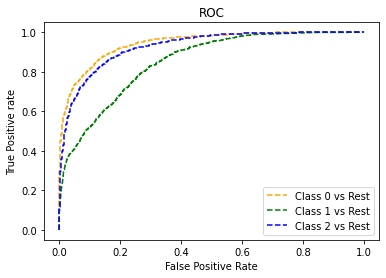

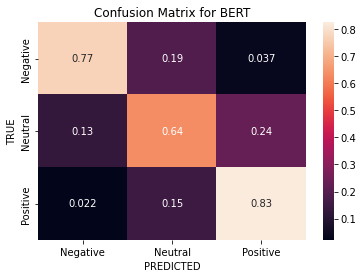

In [29]:
plot_multiROC(pred_prob = preds)
plot_conf_matrix(conf_matrix = conf_matrix)